In [1]:
import torch
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics.functional import multiclass_accuracy
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Ilin\anaconda3\envs\pytorch_testing\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


Setting up file paths and some other things for converting image data to tensors.

In [2]:
training_path ='./archive/Train Images 13440x32x32/train/'
test_path ='./archive/Test Images 3360x32x32/test/'


train_files=os.listdir(training_path)
test_files=os.listdir(test_path)
transform=transforms.Compose([transforms.ToTensor()])


In [3]:
def data_builder(path, files):
    '''Function for converting image data to tensors for using in training, along with getting the labels
       from the file name.
    '''
    img_fordim=cv2.imread(os.path.join(path,files[0]), 0)
    image_size=torch.flatten(transform(img_fordim))
    dim1=image_size.shape[0]
    dim0=len(files)
    data=torch.zeros((dim0, dim1))
    labels=torch.zeros((dim0, 1))
    for i, file in enumerate(files):
        img=cv2.imread(os.path.join(path,file), 0)
        flat_tens=torch.flatten(transform(img))
        data[i]=flat_tens
        label=file.split('_')[-1][:2]
        labels[i]=float(label)-1
        
    return data, labels

In [4]:
device= 'cuda' if torch.cuda.is_available() else "cpu"

device

'cpu'

In [5]:
test_data, test_labels = data_builder(test_path, test_files)

train_data, train_labels = data_builder(training_path, train_files)


In [56]:
torch.save(test_data, 'test_data.pt')
torch.save(test_labels, 'test_labels.pt')
torch.save(train_data, 'train_data.pt')
torch.save(train_labels, 'train_labels.pt')

In [166]:
class ArabicCharClassifier(nn.Module):
    def __init__(self, n_char):
        super().__init__()
        self.hidden1=nn.Linear(1024, 100)
        self.hidden2=nn.Linear(100, 100)
        self.hidden3=nn.Linear(100,100)
        self.hidden4=nn.Linear(100,100)
        self.hidden5=nn.Linear(100,100)
        self.hiddenfin=nn.Linear(100, n_char)
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout()
        self.batch1=nn.BatchNorm1d(100)
        self.batch2=nn.BatchNorm1d(100)
        self.batch3=nn.BatchNorm1d(100)
        self.batch4=nn.BatchNorm1d(100)
        self.batch5=nn.BatchNorm1d(100)
        
    def forward(self, x):
        X = self.hidden1(x)
        X = self.relu(X)
        X = self.batch1(X)
        X = self.dropout(X)
        
        X = self.hidden2(X)
        X = self.relu(X)
        X = self.batch2(X)
        X = self.dropout(X)
        
        X = self.hidden3(X)
        X = self.relu(X)
        X = self.batch3(X)
        X = self.dropout(X)
        
        X = self.hidden4(X)
        X = self.relu(X)
        X = self.batch4(X)
        X = self.dropout(X)
        
        X = self.hidden5(X)
        X = self.relu(X)
        X = self.batch5(X)
        X = self.dropout(X)
        
        
        
        X = self.hiddenfin(X)
        
        return X
    

In [172]:
model=ArabicCharClassifier(n_char=28).to(device)
model

ArabicCharClassifier(
  (hidden1): Linear(in_features=1024, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=100, bias=True)
  (hidden4): Linear(in_features=100, out_features=100, bias=True)
  (hidden5): Linear(in_features=100, out_features=100, bias=True)
  (hiddenfin): Linear(in_features=100, out_features=28, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batch1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [173]:
loss = nn.CrossEntropyLoss()

optimization = optim.Adam(params=model.parameters(), lr=0.001)

In [174]:
def metrics(y_pred, y_true, num_char):
    acc = multiclass_accuracy(y_pred, y_true)
    f1_score = multiclass_f1_score(y_pred, y_true, num_classes=num_char)
    return f1_score, acc 

In [ ]:
num_epoch = 200

train_data, train_labels = train_data.to(device), train_labels.to(device)

test_data, test_labels = test_data.to(device), test_labels.to(device)

train_metrics={'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

test_metrics = {'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

for epoch in range(num_epoch):
    
    train_pred=model(train_data)
    model.train()
    
    
    
    y_train = torch.squeeze(train_labels).type(torch.LongTensor) 
    
    optimization.zero_grad()
    
    loss_epoch = loss(train_pred, y_train)
    
    f1_train, acc_train = metrics(train_pred, y_train, 28)
    
    loss_epoch.backward()
    
    optimization.step()
    
    train_metrics['loss'].append(loss_epoch.item())
    train_metrics['accuracy'].append(acc_train.item()*100)
    train_metrics['f1_score'].append(f1_train.item())
    
    model.eval()
    with torch.inference_mode():
        test_pred = model(test_data)
        y_eval = torch.squeeze(test_labels).type(torch.LongTensor) 
        loss_eval=loss(test_pred, y_eval)
        f1_test, acc_test = metrics(test_pred, torch.squeeze(test_labels), 28)
        
        test_metrics['accuracy'].append(acc_test.item()*100)
        test_metrics['f1_score'].append(f1_test.item())
        test_metrics['loss'].append(loss_eval.item())
        
        
    if epoch%10==0:
        print(f'Epoch: {epoch} | Train loss: {loss_epoch:.5f} | Train accuracy: {acc_train*100:.3f}% | Train f1 {f1_train:.3f} | Test accuracy {acc_test*100:.3f}% | Test f1 {f1_test:.3f}')
        
        
    

Epoch: 0 | Train loss: 3.64813 | Train accuracy: 3.311% | Train f1 0.033 | Test accuracy 3.571% | Test f1 0.036
Epoch: 10 | Train loss: 3.33161 | Train accuracy: 3.571% | Train f1 0.036 | Test accuracy 3.571% | Test f1 0.036
Epoch: 20 | Train loss: 3.32792 | Train accuracy: 5.394% | Train f1 0.054 | Test accuracy 5.923% | Test f1 0.059
Epoch: 30 | Train loss: 3.31298 | Train accuracy: 10.156% | Train f1 0.102 | Test accuracy 10.982% | Test f1 0.110


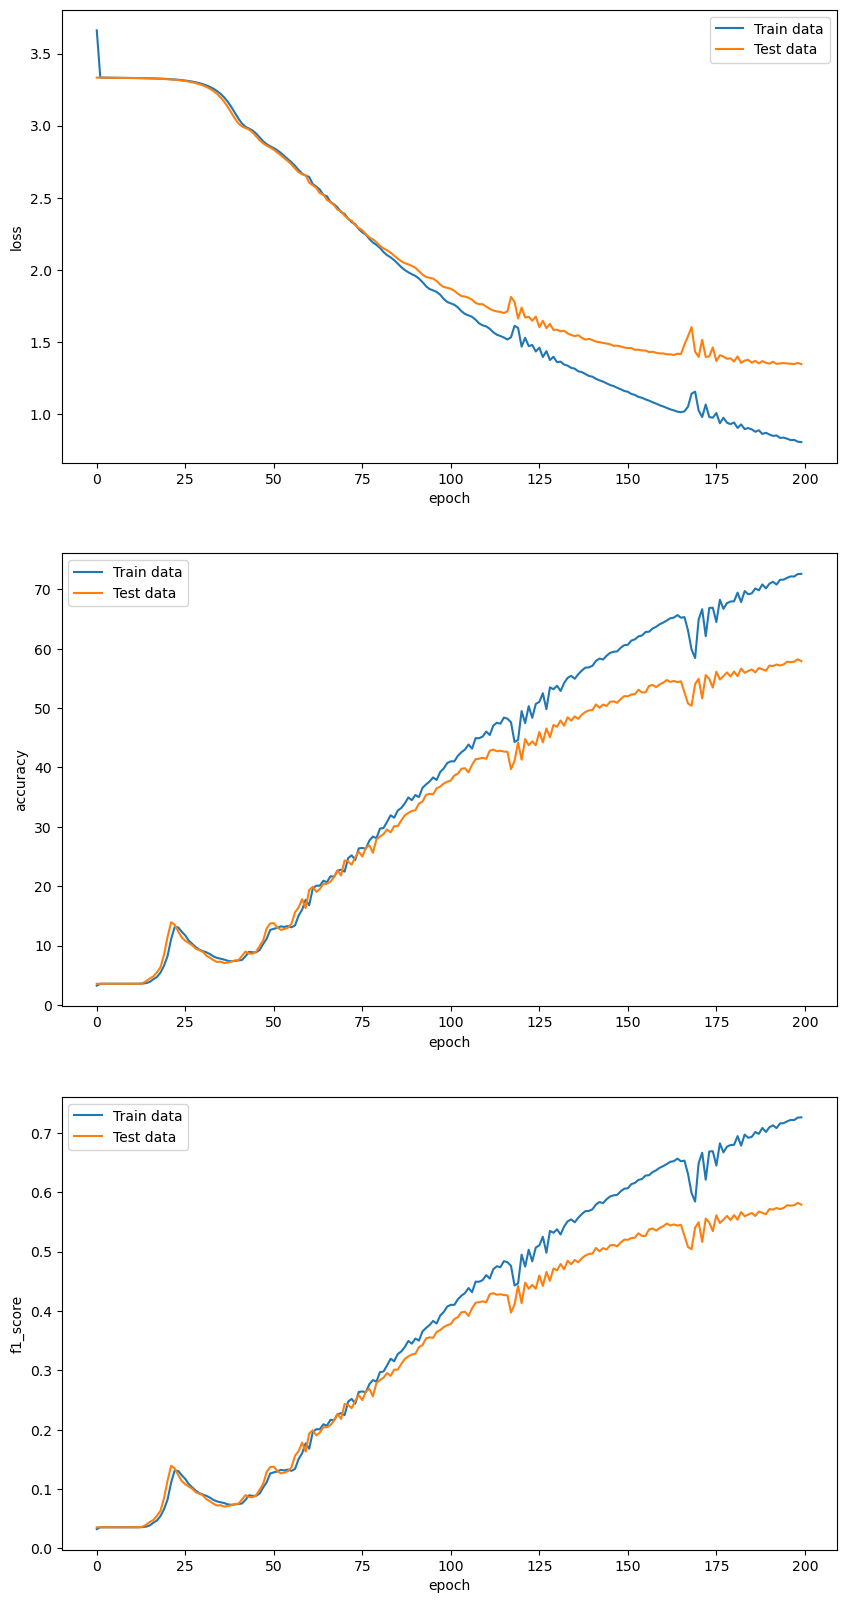

In [171]:
fig, axs = plt.subplots(3, figsize=(10,20))
sns.lineplot(data=train_metrics, x='epoch', y='loss', label='Train data', ax=axs[0])
sns.lineplot(data=test_metrics, x='epoch', y='loss', label='Test data', ax=axs[0])
sns.lineplot(data=train_metrics, x='epoch', y='accuracy', label='Train data', ax=axs[1])
sns.lineplot(data=test_metrics, x='epoch', y='accuracy', label='Test data', ax=axs[1])
sns.lineplot(data=train_metrics, x='epoch', y='f1_score', label='Train data', ax=axs[2])
sns.lineplot(data=test_metrics, x='epoch', y='f1_score', label='Test data', ax=axs[2])
plt.legend()